In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import eegbci
from mne.preprocessing import ICA
from scipy.signal import welch
from scipy.stats import zscore

# CONFIG

SUBJECTS = [1, 2, 3, 4, 5]          # Among 109 samples 5 samples are used in this project for grneralization
RUNS = [4,8,12]          # MI runs for imagine opening and closing left or right fist
MI_BAND = (8., 30.)
ICA_BAND = (1., 40.)
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#  DATA QUALITY CHECK FUNCTIONS

def check_missingness(X, label=""):
    print(f"\n=== Missingness Check {label} ===")
    nan_count = np.isnan(X).sum()
    print(f"Total NaNs: {nan_count}")


def check_high_amplitude_artifacts(X, threshold=150e-6, label=""):
    print(f"\n=== High-Amplitude Artifact Check {label} ===")
    max_vals = np.max(np.abs(X), axis=2)
    bad_epochs = np.where(max_vals > threshold)
    print(f"Epochs exceeding {threshold} V: {len(bad_epochs[0])}")


def check_emg_artifacts(X, sfreq, hf_band=(30, 100), label=""):
    print(f"\n=== EMG Artifact Check (High-Frequency Power) {label} ===")
    emg_scores = []
    for trial in X:
        f, Pxx = welch(trial.mean(axis=0), fs=sfreq, nperseg=256)
        hf_power = Pxx[(f >= hf_band[0]) & (f <= hf_band[1])].mean()
        emg_scores.append(hf_power)

    print("Mean HF power:", np.mean(emg_scores))
    print("Max HF power:", np.max(emg_scores))


def detect_outlier_epochs(X, z_thresh=4, label=""):
    print(f"\n=== Outlier Detection (Z-score) {label} ===")
    X_flat = X.reshape(X.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outliers = np.where(np.max(z, axis=1) > z_thresh)[0]
    print(f"Outlier epochs detected: {len(outliers)}")


def check_duplicates(X, label=""):
    print(f"\nDuplicate Epoch Check {label}")
    X_flat = X.reshape(X.shape[0], -1)
    unique = np.unique(X_flat, axis=0)
    print(f"Duplicates: {X_flat.shape[0] - unique.shape[0]}")


def check_class_balance(y, label=""):
    print(f"\n=== Class Balance Check {label} ===")
    unique, counts = np.unique(y, return_counts=True)
    print(dict(zip(unique, counts)))


# RAW EPOCHS FOR ARTIFACT PRESENCE CHECK

def load_and_filter_subject(subj):
    print(f"\nLoading subject {subj}")
    raw_files = eegbci.load_data(subj, RUNS)
    raws = [mne.io.read_raw_edf(f, preload=True) for f in raw_files]

    for raw in raws:
        raw.filter(MI_BAND[0], MI_BAND[1], fir_design='firwin')

    raw = mne.concatenate_raws(raws)
    return raw


def extract_raw_epochs(raw):
    events, event_id = mne.events_from_annotations(raw)
    event_id = {'T1': 1, 'T2': 2}

    epochs = mne.Epochs(
        raw, events, event_id,
        tmin=0.5, tmax=2.5,
        baseline=None, preload=True
    )

    X = epochs.get_data()
    y = epochs.events[:, -1] - 1
    return X, y, raw.info['sfreq']



# MAIN: 


def main():
    all_X_raw, all_y_raw = [], []
    sfreq = None

    for subj in SUBJECTS:
        # 1) Load + filter
        raw = load_and_filter_subject(subj)

        # 2) Raw epochs → check presence of artifacts
        X_raw, y_raw, sfreq = extract_raw_epochs(raw)
        all_X_raw.append(X_raw)
        all_y_raw.append(y_raw)

    X_raw_all = np.concatenate(all_X_raw)
    y_raw_all = np.concatenate(all_y_raw)


    print(" RAW DATA QUALITY CHECKS (BEFORE PREPROCESSING)")

    check_missingness(X_raw_all, label="(Raw)")
    check_high_amplitude_artifacts(X_raw_all, label="(Raw)")
    check_emg_artifacts(X_raw_all, sfreq, label="(Raw)")
    detect_outlier_epochs(X_raw_all, label="(Raw)")
    check_duplicates(X_raw_all, label="(Raw)")
    check_class_balance(y_raw_all, label="(Raw)")

    return X_raw_all, y_raw_all, sfreq
if __name__ == "__main__":
    main()



Loading subject 1


C:\Users\Pralhad\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Pralhad\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Pralhad\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- 

In [133]:
import numpy as np
import mne
from mne.datasets import eegbci
from mne.preprocessing import ICA
from scipy.signal import welch
from scipy.stats import zscore
from sklearn.utils import resample


# LOAD + FILTER + ICA + ARTIFACT REMOVAL

def preprocess_subject(subj):
    print(f"Preprocessing Subject {subj}")

    # Load raw EDF files

    raw_files = eegbci.load_data(subj, RUNS)
    raws = [mne.io.read_raw_edf(f, preload=True) for f in raw_files]

    # MI-specific bandpass
    for raw in raws:
        raw.filter(MI_BAND[0], MI_BAND[1], fir_design='firwin')

    raw = mne.concatenate_raws(raws)


    # ICA preprocessing

    raw_ica = raw.copy().filter(ICA_BAND[0], ICA_BAND[1], fir_design='firwin')
    raw_ica.set_eeg_reference('average', projection=False)

    ica = ICA(n_components=20, random_state=97, max_iter='auto')
    ica.fit(raw_ica)


    # Detect EOG components

    eog_inds = []
    for ch in ['Fp1.', 'Fp2.', 'F7.', 'F8.']: # These chaneels contains EOG artifacts
        if ch in raw_ica.ch_names:
            inds, _ = ica.find_bads_eog(raw_ica, ch_name=ch)
            eog_inds.extend(inds)
    eog_inds = list(set(eog_inds))


    # Detect EMG components (high-frequency power)

    emg_inds = []
    sources = ica.get_sources(raw_ica).get_data()
    sfreq = raw_ica.info['sfreq']

    for idx in range(ica.n_components_):
        src = sources[idx]
        psd, freqs = mne.time_frequency.psd_array_welch(
            src, sfreq=sfreq, fmin=20., fmax=100., n_fft=512
        )
        if psd.mean() > np.percentile(psd, 75):
            emg_inds.append(idx)

    emg_inds = list(set(emg_inds) - set(eog_inds))


    # Remove ICA components

    ica.exclude = list(set(eog_inds + emg_inds))
    raw_clean = ica.apply(raw.copy())

    return raw_clean



# EPOCHING + CLEANING BAD EPOCHS


def extract_and_clean_epochs(raw_clean):
    events, event_id = mne.events_from_annotations(raw_clean)
    event_id = {'T1': 1, 'T2': 2}

    epochs = mne.Epochs(
        raw_clean, events, event_id,
        tmin=0.5, tmax=2.5,
        baseline=None, preload=True
    )

    X = epochs.get_data()
    y = epochs.events[:, -1] - 1
    sfreq = raw_clean.info['sfreq']


    # Remove missing values

    nan_mask = ~np.isnan(X).any(axis=(1, 2))
    X = X[nan_mask]
    y = y[nan_mask]


    # Remove high-amplitude artifacts

    amp_mask = np.max(np.abs(X), axis=2) < 150e-6
    amp_mask = amp_mask.all(axis=1)
    X = X[amp_mask]
    y = y[amp_mask]


    # Remove outliers (Z-score)

    X_flat = X.reshape(X.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outlier_mask = np.max(z, axis=1) < 4
    X = X[outlier_mask]
    y = y[outlier_mask]

    return X, y, sfreq


# CLASS BALANCING (OVERSAMPLING) 
def balance_classes(X, y):
    # Separate classes 
    X0 = X[y == 0] 
    X1 = X[y == 1] 
    n0, n1 = len(X0), len(X1) 
    max_n = max(n0, n1)
    # Oversample minority class 
    if n0 < max_n: 
        X0 = resample(X0, replace=True, n_samples=max_n, random_state=42) 
    if n1 < max_n: 
        X1 = resample(X1, replace=True, n_samples=max_n, random_state=42) 
# Recombine 
    X_bal = np.concatenate([X0, X1]) 
    y_bal = np.array([0]*max_n + [1]*max_n) 
# Shuffle 
    idx = np.random.permutation(len(y_bal)) 
    return X_bal[idx], y_bal[idx]
# FULL PIPELINE FOR MULTIPLE SUBJECTS


def preprocess_all(subjects):
    all_X, all_y = [], []
    sfreq = None

    for subj in subjects:
        raw_clean = preprocess_subject(subj)
        X, y, sfreq = extract_and_clean_epochs(raw_clean)
        all_X.append(X)
        all_y.append(y)

    X_all = np.concatenate(all_X)
    y_all = np.concatenate(all_y)

    X_all, y_all = balance_classes(X_all, y_all)

    print("\nFinal Clean Dataset")
    print("X shape:", X_all.shape)
    print("y shape:", y_all.shape)

    return X_all, y_all, sfreq


In [134]:

#RE-CHECK ARTIFACTS & MISSINGNESS AFTER PREPROCESSING


def run_post_preprocessing_checks(X_clean, y_clean, sfreq):


    # Missingness
    print("\nMissingness After Cleaning ")
    print("Total NaNs:", np.isnan(X_clean).sum())

    # High amplitude artifacts
    print("\nHigh-Amplitude Artifacts After Cleaning")
    max_vals = np.max(np.abs(X_clean), axis=2)
    bad_epochs = np.where(max_vals > 150e-6)
    print(f"Epochs exceeding 150 µV: {len(bad_epochs[0])}")

    # EMG artifacts
    print("\nEMG High-Frequency Power After Cleaning")
    emg_scores = []
    for trial in X_clean:
        f, Pxx = welch(trial.mean(axis=0), fs=sfreq, nperseg=256)
        hf_power = Pxx[(f >= 30) & (f <= 100)].mean()
        emg_scores.append(hf_power)
    print("Mean HF power:", np.mean(emg_scores))
    print("Max HF power:", np.max(emg_scores))

    # Outliers
    print("\nOutliers After Cleaning (Z-score)")
    X_flat = X_clean.reshape(X_clean.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outliers = np.where(np.max(z, axis=1) > 4)[0]
    print(f"Outlier epochs detected: {len(outliers)}")

    # Duplicates
    print("\nDuplicate Epochs After Cleaning")
    unique = np.unique(X_flat, axis=0)
    print(f"Duplicates: {X_flat.shape[0] - unique.shape[0]}")

    # Class balance
    print("\nClass Balance After Cleaning")
    unique_y, counts = np.unique(y_clean, return_counts=True)
    print(dict(zip(unique_y, counts)))


In [135]:
X_all, y_all, sfreq = preprocess_all([1, 2, 3, 4, 5])
run_post_preprocessing_checks(X_all, y_all, sfreq)


Preprocessing Subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

In [136]:
X_raw_all, y_raw_all, sfreq_raw = main()



Loading subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

In [137]:
def compute_metrics(X, y, sfreq):
    # Missingness
    missing = np.isnan(X).sum()

    # High amplitude artifacts
    max_vals = np.max(np.abs(X), axis=2)
    high_amp = np.sum(max_vals > 150e-6)

    # EMG high-frequency power
    emg_scores = []
    for trial in X:
        f, Pxx = welch(trial.mean(axis=0), fs=sfreq, nperseg=256)
        hf_power = Pxx[(f >= 30) & (f <= 100)].mean()
        emg_scores.append(hf_power)
    emg_mean = np.mean(emg_scores)

    # Outliers
    X_flat = X.reshape(X.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outliers = np.sum(np.max(z, axis=1) > 4)

    # Duplicates
    unique = np.unique(X_flat, axis=0)
    duplicates = X_flat.shape[0] - unique.shape[0]

    # Class imbalance (difference between class counts)
    unique_y, counts = np.unique(y, return_counts=True)
    if len(counts) == 2:
        class_imbalance = abs(counts[0] - counts[1])
    else:
        class_imbalance = 0  # fallback

    return [missing, high_amp, emg_mean, outliers, duplicates, class_imbalance]


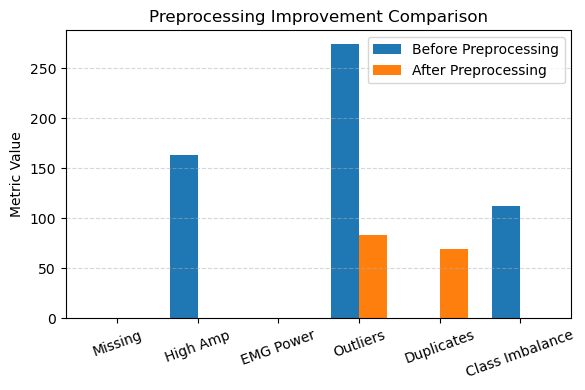

In [138]:
before_metrics = compute_metrics(X_raw_all, y_raw_all, sfreq_raw)
after_metrics = compute_metrics(X_all, y_all, sfreq)

labels = ["Missing", "High Amp", "EMG Power", "Outliers", "Duplicates", "Class Imbalance"]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, before_metrics, width, label='Before Preprocessing')
plt.bar(x + width/2, after_metrics, width, label='After Preprocessing')

plt.xticks(x, labels, rotation=20)
plt.ylabel("Metric Value")
plt.title("Preprocessing Improvement Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Preprocessing Improvement Comparison.png", dpi=300, bbox_inches='tight')

plt.show()


In [139]:
import matplotlib.pyplot as plt

def plot_eeg_overlay(X_raw, X_clean, sfreq, channel=0, trial=0):
    """
    Overlay raw vs cleaned EEG for visual comparison.
    """

    raw_sig = X_raw[trial, channel, :]
    clean_sig = X_clean[trial, channel, :]

    t = np.arange(len(raw_sig)) / sfreq

    plt.figure(figsize=(8, 4))

    plt.plot(t, raw_sig, color='red', alpha=0.6, label='Before Preprocessing')
    plt.plot(t, clean_sig, color='green', alpha=0.8, label='After Preprocessing')

    plt.title(f"EEG Before vs After Preprocessing\nChannel {channel}, Trial {trial}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("EEG Before vs After Preprocessing Channel 10 Trial 1", dpi=300, bbox_inches='tight')
    plt.show()


In [140]:
X_raw_all, y_raw_all, sfreq_raw = main()
X_all, y_all, sfreq = preprocess_all([1,2,3,4,5])



Loading subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

<Figure size 640x480 with 0 Axes>

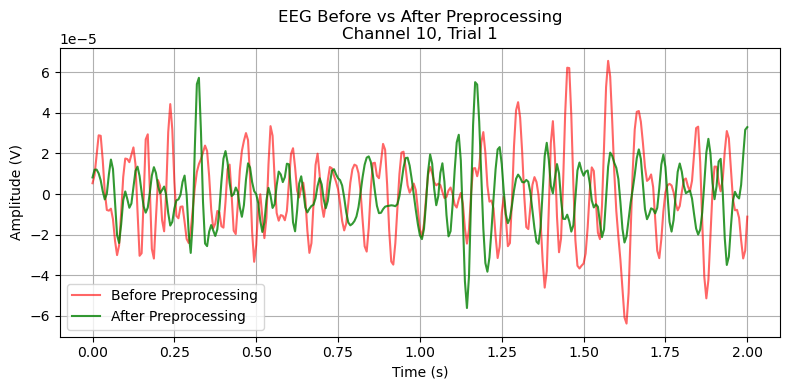

In [141]:
plt.savefig("EEG Before vs After Preprocessing: Channel =10, Trial=1", dpi=300, bbox_inches='tight')
plot_eeg_overlay(X_raw_all, X_all, sfreq, channel=10, trial=1)


In [142]:
def preprocess_subject_with_raw(subj):

    # RAW (before preprocessing) ---
    raw = load_and_filter_subject(subj)
    X_raw, y_raw, sfreq = extract_raw_epochs(raw)

    # --- CLEAN (after preprocessing) ---
    raw_clean = preprocess_subject(subj)
    X_clean, y_clean, sfreq = extract_and_clean_epochs(raw_clean)

    return X_raw, X_clean, sfreq


In [143]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_channels_grid(X_raw, X_clean, sfreq, subj, trial=0):
    """
    Plot all EEG channels for a subject in a grid.
    Raw (red) and Clean (green) signals are overlaid.
    """

    n_channels = X_raw.shape[1]
    n_cols = 8                      # 8 columns → 8x8 grid for 64 channels
    n_rows = int(np.ceil(n_channels / n_cols))

    t = np.arange(X_raw.shape[2]) / sfreq

    plt.figure(figsize=(18, 12))
    plt.suptitle(f"Subject {subj} — All Channels (Trial {trial})\nRaw vs Clean", fontsize=16)

    for ch in range(n_channels):
        plt.subplot(n_rows, n_cols, ch + 1)

        plt.plot(t, X_raw[trial, ch, :], color='red', alpha=0.5)
        plt.plot(t, X_clean[trial, ch, :], color='green', alpha=0.7)

        plt.title(f"Ch {ch}", fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig("All channel Raw vs Clean", dpi=300, bbox_inches='tight')
    plt.show()



Loading subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

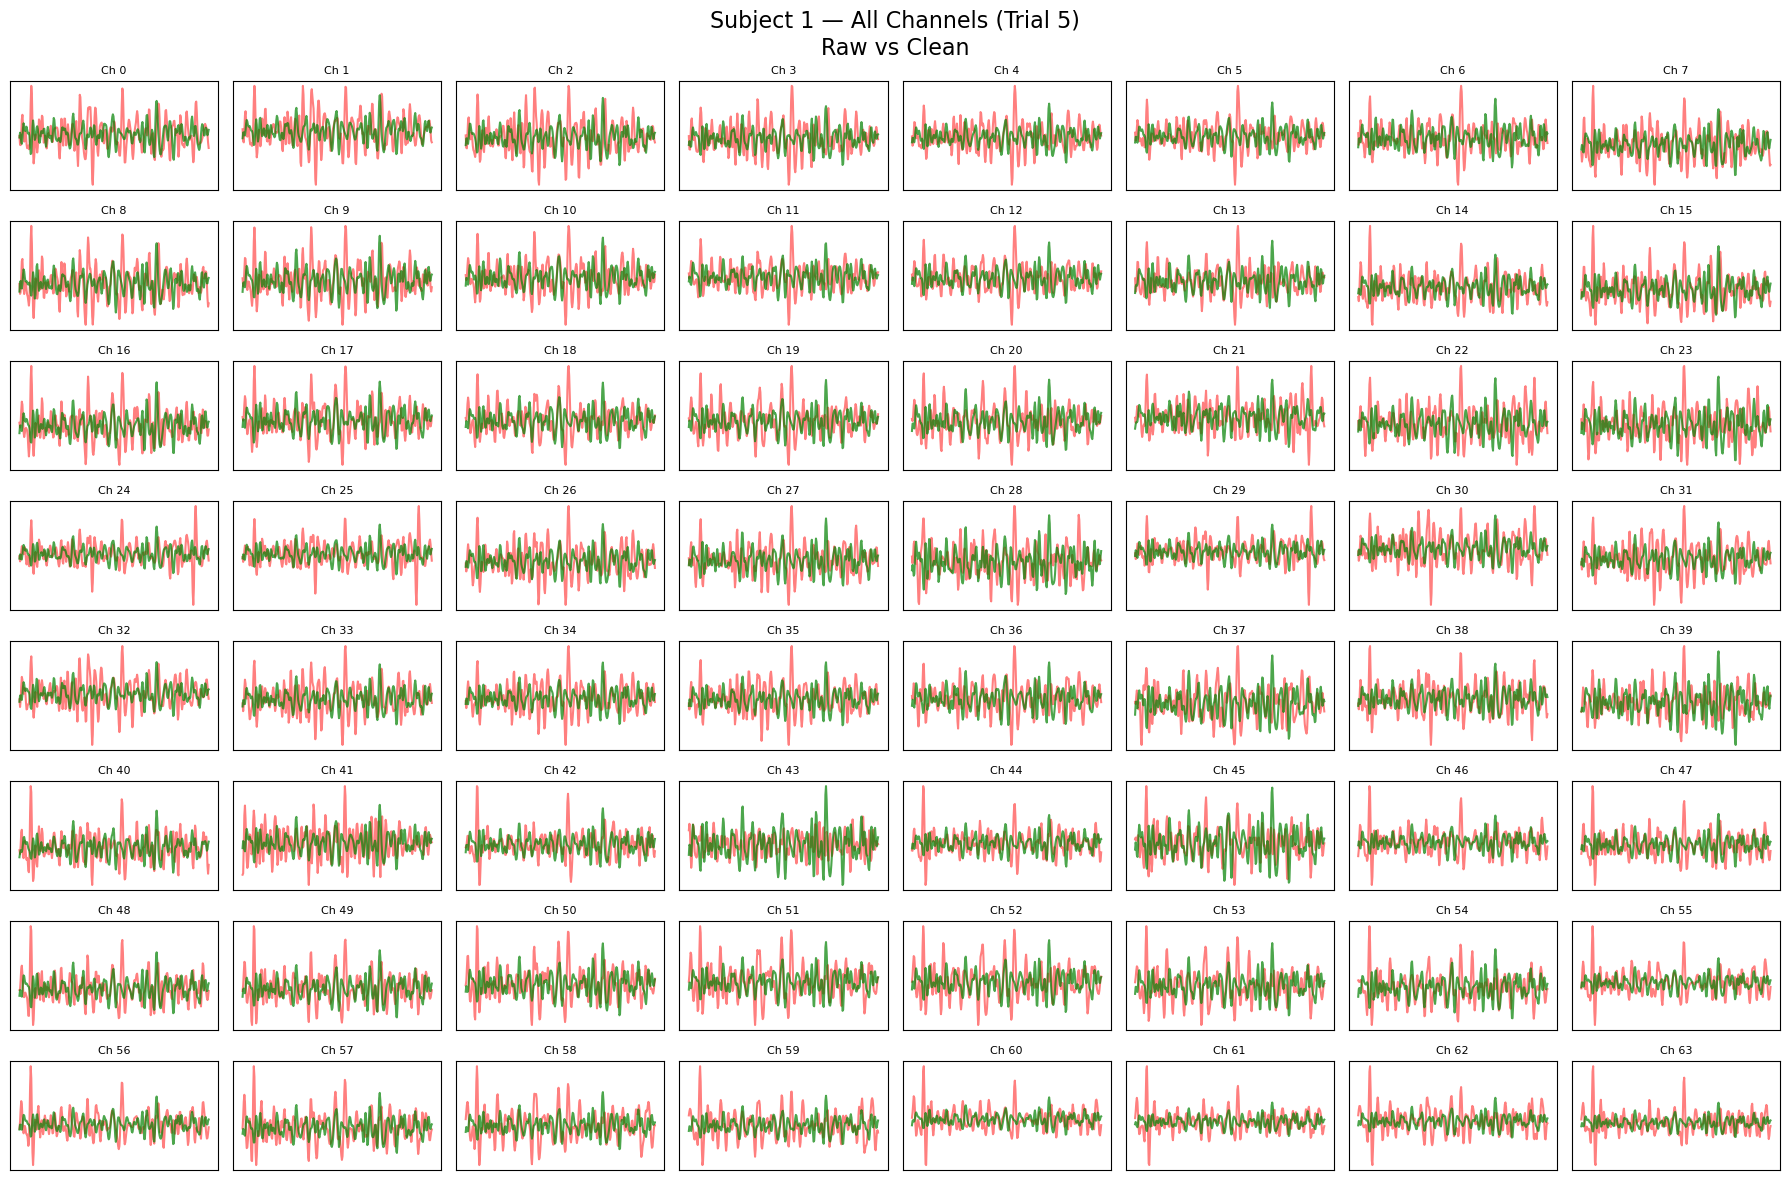

In [144]:
X_raw, X_clean, sfreq = preprocess_subject_with_raw(subj=1)
plot_all_channels_grid(X_raw, X_clean, sfreq, subj=1, trial=5)


In [145]:
from scipy.signal import welch
import numpy as np

def compute_temporal_features(X, sfreq):
    n_trials, n_channels, n_times = X.shape
    feats = []

    for trial in range(n_trials):
        trial_feats = []
        data = X[trial]  # (n_channels, n_times)

        for ch in range(n_channels):
            x = data[ch]

            # Time-domain stats
            mean = x.mean()
            var  = x.var()

            # Bandpower via Welch
            f, Pxx = welch(x, fs=sfreq, nperseg=256)

            mu_band   = (8, 12)
            beta_band = (13, 30)

            mu_power = Pxx[(f >= mu_band[0]) & (f <= mu_band[1])].mean()
            beta_power = Pxx[(f >= beta_band[0]) & (f <= beta_band[1])].mean()

            trial_feats.extend([mean, var, mu_power, beta_power])

        feats.append(trial_feats)

    return np.array(feats)  # shape: (n_trials, n_channels * 4)

In [242]:
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#sfreq = raw_clean.info['sfreq']  # from  data

# Train-test split as before
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# 1) Temporal features
X_train_temp = compute_temporal_features(X_train, sfreq)
X_test_temp  = compute_temporal_features(X_test, sfreq)

# 2) CSP features
csp = CSP(n_components=6)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp  = csp.transform(X_test)

# 3) Concatenate
X_train_feat = np.concatenate([X_train_csp, X_train_temp], axis=1)
X_test_feat  = np.concatenate([X_test_csp, X_test_temp], axis=1)

print("Feature shape:", X_train_feat.shape)

Computing rank from data with rank=None
    Using tolerance 0.00031 (2.2e-16 eps * 64 dim * 2.2e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Feature shape: (204, 262)


In [269]:
import pandas as pd
import numpy as np

# Save training features
df_train = pd.DataFrame(X_train_feat)
df_train['label'] = y_train
df_train.to_csv("EEG_train_features.csv", index=False)

# Save testing features
df_test = pd.DataFrame(X_test_feat)
df_test['label'] = y_test
df_test.to_csv("EEG_test_features.csv", index=False)

print("CSV files saved successfully.")


CSV files saved successfully.


In [272]:
import pandas as pd

df_train = pd.DataFrame(X_train_feat)
df_train['label'] = y_train

# Print all rows without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df_train)


            0         1         2         3         4         5             6  \
0   -2.140537 -2.436769 -0.527161 -2.100870 -0.250228 -2.021290 -3.492308e-08   
1   -0.260219 -0.910993 -1.309717  0.078922 -1.705006 -0.354474 -1.193594e-07   
2   -0.501856 -1.199836 -1.851452 -0.025040 -2.255430 -0.320259  7.961958e-08   
3   -2.092469 -2.307147 -0.454893 -2.097291 -0.043037 -1.601517 -5.997286e-08   
4    0.213522 -0.392922 -1.920164  0.010177 -1.870886  0.644130  3.241016e-07   
5   -0.513396 -0.666731 -2.260876 -0.676214 -2.054108 -0.115704 -8.655740e-08   
6   -1.870977 -2.139308 -0.785802 -1.953005 -0.618844 -1.593051 -5.024014e-09   
7   -0.467692 -1.052511 -1.365749  0.099898 -1.941253 -0.441097  2.595603e-08   
8   -0.883929 -0.265321 -0.514667 -0.986800 -0.130306 -0.971419  7.584998e-08   
9   -0.486421 -0.853358 -1.354122  0.534370 -1.948496 -0.305347  7.024097e-08   
10  -0.327342 -0.916514 -1.145760  0.641770 -2.188493 -0.236686 -1.474085e-07   
11  -0.157486 -0.829042 -1.7